# Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score
from scipy.optimize import differential_evolution
import pygad
from TfELM.Layers.ELMLayer import ELMLayer
from TfELM.Models.ELMModel import ELMModel

import warnings
warnings.filterwarnings("ignore")

# Wine Dataset

## Load Dataset

In [6]:
from sklearn.datasets import load_wine

data = load_wine()
df_wine = pd.DataFrame(data.data, columns=data.feature_names)
df_wine['Wine'] = data.target

print(df_wine.shape)
print("Wine 1:", df_wine[df_wine['Wine']==0].shape[0])
print("Wine 2:", df_wine[df_wine['Wine']==1].shape[0])
print("Wine 3:", df_wine[df_wine['Wine']==2].shape[0])

(178, 14)
Wine 1: 59
Wine 2: 71
Wine 3: 48


## Split train-test

In [7]:
X = df_wine.drop(columns=["Wine"])
y = df_wine["Wine"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=42) # stratify para balanceamento das classes

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (133, 13)
X_test: (45, 13)


## Apply z-score in data train and data test

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline Model

##### All features and default values for MLP

In [9]:
clf = MLPClassifier(random_state=42).fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("*** Baseline MLPClassifier ***")
print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred, average='weighted'),4))
print("F1 Score:", round(f1_score(y_test, y_pred, average='weighted'),4))
print("Recall:", round(recall_score(y_test, y_pred, average='weighted'),4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

*** Baseline MLPClassifier ***
Accuracy: 0.9778
Precision: 0.9789
F1 Score: 0.9776
Recall: 0.9778
Confusion Matrix:
 [[15  0  0]
 [ 0 18  0]
 [ 0  1 11]]


## Differential Evolution (DE) + Backpropagation (BP)

In [6]:
feature_names = X.columns.tolist()
n_features = X_train_scaled.shape[1]

def fitness(individual):
    feature_mask = individual[:n_features] > 0.5
    if not any(feature_mask):
        return 10.0  # penaliza se nenhuma feature for selecionada

    n_layers = int(np.clip(round(individual[n_features]), 1, 5))
    n_neurons = int(np.clip(round(individual[n_features + 1]), 10, 100))
    learning_rate = individual[n_features+2]

    hidden_layer_sizes = tuple([n_neurons] * n_layers) # cria tupla com o número de camadas ocultas e com mesmo número de neurônios
    X_sel = X_train_scaled[:, feature_mask] # seleciona as features com base no mask
    # MLPClassifier com os parâmetros selecionados.
    # Por padrão camada de entrada e saída são definidas automaticamente
    # Camada de entrada tem o mesmo número de features selecionadas e a camada de saída tem o mesmo número de classes
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        learning_rate_init=learning_rate)

    try:
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean() # cross-validation com 3 folds
    except:
        return 10.0

    return 1.0 - score  # minimizar o erro

# DE com os parâmetros do problema
bounds = [(0, 1)] * n_features + [(1, 5), (10, 100), (0.0001, 0.1)]

result = differential_evolution(
    fitness, bounds, maxiter=20, popsize=50, disp=True,
    mutation=(0.5,1), recombination=0.95, strategy='best1bin'
)

# Avaliando resultado do melhor indivíduo encontrado
best_individual = result.x
selected_features = best_individual[:n_features] > 0.5
n_layers_best = int(round(best_individual[n_features]))
n_neurons_best = int(round(best_individual[n_features+1]))
lr_best = best_individual[n_features+2]

print("\nMelhores configurações encontradas:")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de camadas ocultas: {n_layers_best}")
print(f"- Número de neurônios por camada: {n_neurons_best}")
print(f"- Taxa de aprendizado: {lr_best:.5f}")

# Treina modelo final com os melhores parâmetros
clf_final = MLPClassifier(
    hidden_layer_sizes=(n_neurons_best,) * n_layers_best,
    learning_rate_init=lr_best,
    random_state=42
)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
y_pred = clf_final.predict(X_test_sel)

print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred, average='weighted'),4))
print("F1 Score:", round(f1_score(y_test, y_pred, average='weighted'),4))
print("Recall:", round(recall_score(y_test, y_pred, average='weighted'),4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

differential_evolution step 1: f(x)= 0.007575757575757458
differential_evolution step 2: f(x)= 0.007575757575757458
differential_evolution step 3: f(x)= 0.0
differential_evolution step 4: f(x)= 0.0
differential_evolution step 5: f(x)= 0.0
differential_evolution step 6: f(x)= 0.0
differential_evolution step 7: f(x)= 0.0
differential_evolution step 8: f(x)= 0.0
differential_evolution step 9: f(x)= 0.0
differential_evolution step 10: f(x)= 0.0
differential_evolution step 11: f(x)= 0.0
differential_evolution step 12: f(x)= 0.0
differential_evolution step 13: f(x)= 0.0
differential_evolution step 14: f(x)= 0.0
differential_evolution step 15: f(x)= 0.0
differential_evolution step 16: f(x)= 0.0
differential_evolution step 17: f(x)= 0.0
differential_evolution step 18: f(x)= 0.0
differential_evolution step 19: f(x)= 0.0
differential_evolution step 20: f(x)= 0.0
Polishing solution with 'L-BFGS-B'

Melhores configurações encontradas:
- Features selecionadas: ['alcohol', 'ash', 'alcalinity_of_ash'

## Differential Evolution (DE) + Extreme Learning Machine (ELM)

In [7]:
n_features = X_train_scaled.shape[1]

# A função fitness agora otimiza apenas a seleção de features e o número de neurônios
def fitness(individual):
    feature_mask = individual[:n_features] > 0.5
    if not np.any(feature_mask):
        return 10.0

    # O único hiperparâmetro do ELM a ser otimizado é o número de neurônios.
    n_neurons = int(round(individual[n_features]))
    
    X_sel = X_train_scaled[:, feature_mask]
    
    # MLPClassifier -> ELMClassifier
    # 'number_neurons' é o parâmetro para o número de neurônios da camada oculta
    elm = ELMLayer(number_neurons=n_neurons, activation='relu')
    clf = ELMModel(elm)

    try:
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean()
    except Exception as e:
        # Penaliza se houver qualquer erro durante o treinamento/validação
        return 10.0

    return 1.0 - score  # O objetivo continua sendo minimizar o erro (1 - acurácia)

# bounds apenas para seleção de features e número de neurônios
bounds = [(0, 1)] * n_features + [(10, 1000)]

result = differential_evolution(
    fitness, bounds, maxiter=20, popsize=50, disp=True,
    mutation=(0.5, 1), recombination=0.95, strategy='best1bin'
)

best_individual = result.x
selected_features = best_individual[:n_features] > 0.5
n_neurons_best = int(round(best_individual[n_features]))

print("\nMelhores configurações encontradas:")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de neurônios ocultos (ELM): {n_neurons_best}")

elm = ELMLayer(number_neurons=n_neurons_best, activation='relu')
clf_final = ELMModel(elm)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
y_pred = clf_final.predict(X_test_sel)

print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred, average='weighted'),4))
print("F1 Score:", round(f1_score(y_test, y_pred, average='weighted'),4))
print("Recall:", round(recall_score(y_test, y_pred, average='weighted'),4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

differential_evolution step 1: f(x)= 0.007407407407407418
differential_evolution step 2: f(x)= 0.007407407407407418
differential_evolution step 3: f(x)= 0.007407407407407418
differential_evolution step 4: f(x)= 0.0
differential_evolution step 5: f(x)= 0.0
differential_evolution step 6: f(x)= 0.0
differential_evolution step 7: f(x)= 0.0
differential_evolution step 8: f(x)= 0.0
differential_evolution step 9: f(x)= 0.0
differential_evolution step 10: f(x)= 0.0
differential_evolution step 11: f(x)= 0.0
differential_evolution step 12: f(x)= 0.0
differential_evolution step 13: f(x)= 0.0
differential_evolution step 14: f(x)= 0.0
differential_evolution step 15: f(x)= 0.0
differential_evolution step 16: f(x)= 0.0
differential_evolution step 17: f(x)= 0.0
differential_evolution step 18: f(x)= 0.0
differential_evolution step 19: f(x)= 0.0
differential_evolution step 20: f(x)= 0.0
Polishing solution with 'L-BFGS-B'

Melhores configurações encontradas:
- Features selecionadas: ['alcohol', 'ash', 'a

## Genetic Algorithm (GA) + Backpropagation (BP)

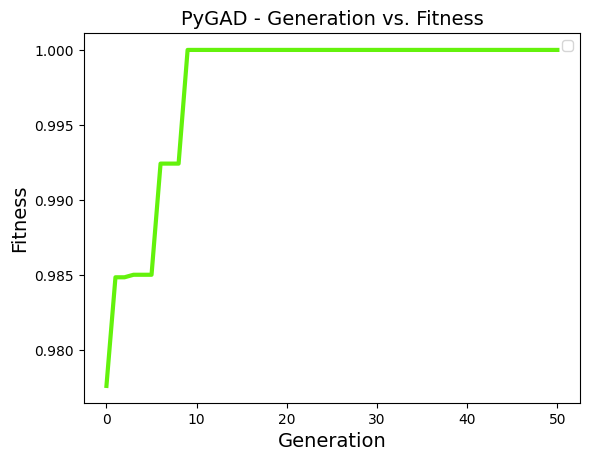


Melhores configurações encontradas:
- Fitness (Acurácia em CV): 1.0000
- Features selecionadas: ['ash', 'alcalinity_of_ash', 'magnesium', 'flavanoids', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
- Número de camadas ocultas: 1
- Número de neurônios por camada: 44
- Taxa de aprendizado: 0.02885
Accuracy: 0.9556
Precision: 0.9569
F1 Score: 0.9554
Recall: 0.9556
Confusion Matrix:
 [[15  0  0]
 [ 1 17  0]
 [ 0  1 11]]


In [8]:
n_features = X_train_scaled.shape[1]
feature_names = X.columns.tolist()

def fitness_func(ga_instance, solution, solution_idx):
    feature_mask = np.array(solution[:n_features]).astype(bool)
    
    # Penaliza se nenhuma característica for selecionada
    if not np.any(feature_mask):
        return -1.0  # PyGAD maximiza, então um valor baixo para penalizar

    # Arredonda os valores para garantir que sejam inteiros
    n_layers = int(round(solution[n_features]))
    n_neurons = int(round(solution[n_features + 1]))
    learning_rate = solution[n_features + 2]

    hidden_layer_sizes = tuple([n_neurons] * n_layers)
    X_sel = X_train_scaled[:, feature_mask]

    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        learning_rate_init=learning_rate
                        )

    try:
        # cross-validation com 3 folds
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean()
    except ValueError:
        # penaliza a solução em caso de erro
        return -1.0

    # PyGAD maximiza a função de fitness por padrão, então a acurácia é retornada diretamente.
    return score

# Define o espaço de busca
gene_space = [ [0, 1] for _ in range(n_features) ] + [ {'low': 1, 'high': 3, 'step': 1}, {'low': 10, 'high': 100, 'step': 1}, {'low': 0.0001, 'high': 0.1} ]

num_genes = len(gene_space)
ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    sol_per_pop=50,
    num_genes=num_genes,
    fitness_func=fitness_func,
    gene_space=gene_space,
    parent_selection_type="tournament",
    crossover_type="two_points",
    mutation_type="random",
    mutation_probability=0.65,
)
ga_instance.run()
ga_instance.plot_fitness()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()

selected_features = best_solution[:n_features].astype(bool)
n_layers_best = int(round(best_solution[n_features]))
n_neurons_best = int(round(best_solution[n_features+1]))
lr_best = best_solution[n_features+2]

print("\nMelhores configurações encontradas:")
print(f"- Fitness (Acurácia em CV): {best_solution_fitness:.4f}")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de camadas ocultas: {n_layers_best}")
print(f"- Número de neurônios por camada: {n_neurons_best}")
print(f"- Taxa de aprendizado: {lr_best:.5f}")

# Treina o modelo final com os melhores parâmetros
clf_final = MLPClassifier(
    hidden_layer_sizes=(n_neurons_best,) * n_layers_best,
    learning_rate_init=lr_best,
    random_state=42
)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
y_pred = clf_final.predict(X_test_sel)

print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred, average='weighted'),4))
print("F1 Score:", round(f1_score(y_test, y_pred, average='weighted'),4))
print("Recall:", round(recall_score(y_test, y_pred, average='weighted'),4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

## Genetic Algorithm (GA) + Extreme Learning Machine (ELM)

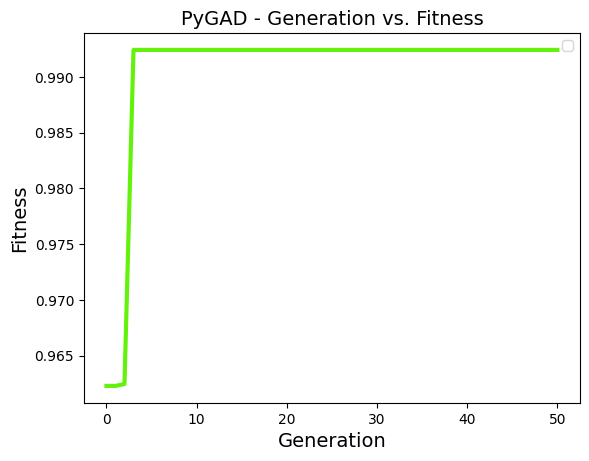


Melhores configurações encontradas:
- Fitness (Acurácia em CV): 0.9924
- Features selecionadas: ['alcohol', 'ash', 'flavanoids', 'nonflavanoid_phenols', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
- Número de neurônios da camada oculta: 16
Accuracy: 1.0
Precision: 1.0
F1 Score: 1.0
Recall: 1.0
Confusion Matrix:
 [[15  0  0]
 [ 0 18  0]
 [ 0  0 12]]


In [9]:
n_features = X_train_scaled.shape[1]
feature_names = X.columns.tolist()

def fitness_func(ga_instance, solution, solution_idx):
    feature_mask = np.array(solution[:n_features]).astype(bool)
    
    # Penaliza se nenhuma característica for selecionada
    if not np.any(feature_mask):
        return -1.0  # PyGAD maximiza, então um valor baixo para penalizar

    # Arredonda os valores para garantir que sejam inteiros
    n_neurons = int(round(solution[n_features + 1]))

    X_sel = X_train_scaled[:, feature_mask]

    elm = ELMLayer(number_neurons=n_neurons, activation='relu')
    clf = ELMModel(elm)

    try:
        # cross-validation com 3 folds
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean()
    except ValueError:
        # penaliza a solução em caso de erro
        return -1.0

    # PyGAD maximiza a função de fitness por padrão, então a acurácia é retornada diretamente.
    return score

for _ in range(n_features):
    gene_space.append({'low': 0, 'high': 1, 'step': 1})
gene_space.append({'low': 10, 'high': 1000, 'step': 1})

num_genes = len(gene_space)
ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    sol_per_pop=50,
    num_genes=num_genes,              
    fitness_func=fitness_func,
    gene_space=gene_space,
    parent_selection_type="tournament",
    crossover_type="two_points",
    mutation_type="random",
    mutation_probability=0.65
)
ga_instance.run()
ga_instance.plot_fitness()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()

selected_features = best_solution[:n_features].astype(bool)
n_neurons_best = int(round(best_solution[n_features + 1]))

print("\nMelhores configurações encontradas:")
print(f"- Fitness (Acurácia em CV): {best_solution_fitness:.4f}")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de neurônios da camada oculta: {n_neurons_best}")

# Treina o modelo final com os melhores parâmetros
elm = ELMLayer(number_neurons=n_neurons_best, activation='relu')
clf_final = ELMModel(elm)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
y_pred = clf_final.predict(X_test_sel)

print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred, average='weighted'),4))
print("F1 Score:", round(f1_score(y_test, y_pred, average='weighted'),4))
print("Recall:", round(recall_score(y_test, y_pred, average='weighted'),4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Diabetes dataset

## Load Dataset

In [10]:
df_diabetes = pd.read_csv("diabetes.csv", sep=",", decimal=".")
print(df_diabetes.shape)

print("Class 0:", df_diabetes[df_diabetes['Outcome']==0].shape[0])
print("Class 1:", df_diabetes[df_diabetes['Outcome']==1].shape[0])

(768, 9)
Class 0: 500
Class 1: 268


## Split train-test

In [11]:
X = df_diabetes.drop(columns=["Outcome"])
y = df_diabetes["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=42)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (576, 8)
X_test: (192, 8)


## Apply z-score in data train and data test

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline Model

##### All features and default values for MLP

In [14]:
clf = MLPClassifier(random_state=42).fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("*** Baseline MLPClassifier ***")
print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred),4))
print("F1 Score:", round(f1_score(y_test, y_pred),4))
print("Recall:", round(recall_score(y_test, y_pred),4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

*** Baseline MLPClassifier ***
Accuracy: 0.7135
Precision: 0.6
F1 Score: 0.5669
Recall: 0.5373
Confusion Matrix:
 [[101  24]
 [ 31  36]]


## Differential Evolution (DE) + Backpropagation (BP)

In [15]:
feature_names = X.columns.tolist()
n_features = X_train_scaled.shape[1]

def fitness(individual):
    feature_mask = individual[:n_features] > 0.5
    if not any(feature_mask):
        return 10.0  # penaliza se nenhuma feature for selecionada

    n_layers = int(np.clip(round(individual[n_features]), 1, 5))
    n_neurons = int(np.clip(round(individual[n_features + 1]), 10, 100))
    learning_rate = individual[n_features+2]

    hidden_layer_sizes = tuple([n_neurons] * n_layers) # cria tupla com o número de camadas ocultas e com mesmo número de neurônios
    X_sel = X_train_scaled[:, feature_mask] # seleciona as features com base no mask
    # MLPClassifier com os parâmetros selecionados.
    # Por padrão camada de entrada e saída são definidas automaticamente
    # Camada de entrada tem o mesmo número de features selecionadas e a camada de saída tem o mesmo número de classes
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        learning_rate_init=learning_rate)

    try:
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean() # cross-validation com 3 folds
    except:
        return 10.0

    return 1.0 - score  # minimizar o erro

# DE com os parâmetros do problema
bounds = [(0, 1)] * n_features + [(1, 5), (10, 100), (0.0001, 0.1)]

result = differential_evolution(
    fitness, bounds, maxiter=25, popsize=10, disp=True,
    mutation=(0.5,1), recombination=0.95, strategy='best1bin'
)

# Avaliando resultado do melhor indivíduo encontrado
best_individual = result.x
selected_features = best_individual[:n_features] > 0.5
n_layers_best = int(round(best_individual[n_features]))
n_neurons_best = int(round(best_individual[n_features+1]))
lr_best = best_individual[n_features+2]

print("\nMelhores configurações encontradas:")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de camadas ocultas: {n_layers_best}")
print(f"- Número de neurônios por camada: {n_neurons_best}")
print(f"- Taxa de aprendizado: {lr_best:.5f}")

# Treina modelo final com os melhores parâmetros
clf_final = MLPClassifier(
    hidden_layer_sizes=(n_neurons_best,) * n_layers_best,
    learning_rate_init=lr_best,
    random_state=42
)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
y_pred = clf_final.predict(X_test_sel)

print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred),4))
print("F1 Score:", round(f1_score(y_test, y_pred),4))
print("Recall:", round(recall_score(y_test, y_pred),4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

differential_evolution step 1: f(x)= 0.23263888888888895
differential_evolution step 2: f(x)= 0.23263888888888895
differential_evolution step 3: f(x)= 0.22395833333333337
differential_evolution step 4: f(x)= 0.22395833333333337
differential_evolution step 5: f(x)= 0.22395833333333337
differential_evolution step 6: f(x)= 0.22395833333333337
differential_evolution step 7: f(x)= 0.22395833333333337
differential_evolution step 8: f(x)= 0.22395833333333337
differential_evolution step 9: f(x)= 0.22395833333333337
differential_evolution step 10: f(x)= 0.22395833333333337
differential_evolution step 11: f(x)= 0.22222222222222232
differential_evolution step 12: f(x)= 0.22222222222222232
differential_evolution step 13: f(x)= 0.22222222222222232
differential_evolution step 14: f(x)= 0.22222222222222232
differential_evolution step 15: f(x)= 0.22222222222222232
differential_evolution step 16: f(x)= 0.22222222222222232
differential_evolution step 17: f(x)= 0.2222222222222222
differential_evolution s

## Differential Evolution (DE) + Extreme Learning Machine (ELM)

In [19]:
n_features = X_train_scaled.shape[1]

# A função fitness agora otimiza apenas a seleção de features e o número de neurônios
def fitness(individual):
    feature_mask = individual[:n_features] > 0.5
    if not np.any(feature_mask):
        return 10.0

    # O único hiperparâmetro do ELM a ser otimizado é o número de neurônios.
    n_neurons = int(round(individual[n_features]))
    
    X_sel = X_train_scaled[:, feature_mask]
    
    # MLPClassifier -> ELMClassifier
    # 'number_neurons' é o parâmetro para o número de neurônios da camada oculta
    elm = ELMLayer(number_neurons=n_neurons, activation='relu')
    clf = ELMModel(elm)

    try:
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean()
    except Exception as e:
        # Penaliza se houver qualquer erro durante o treinamento/validação
        return 10.0

    return 1.0 - score  # O objetivo continua sendo minimizar o erro (1 - acurácia)

# bounds apenas para seleção de features e número de neurônios
bounds = [(0, 1)] * n_features + [(10, 1000)]

result = differential_evolution(
    fitness, bounds, maxiter=50, popsize=10, disp=True,
    mutation=(0.5, 1), recombination=0.95, strategy='best1bin'
)

best_individual = result.x
selected_features = best_individual[:n_features] > 0.5
n_neurons_best = int(round(best_individual[n_features]))

print("\nMelhores configurações encontradas:")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de neurônios ocultos (ELM): {n_neurons_best}")

elm = ELMLayer(number_neurons=n_neurons_best, activation='relu')
clf_final = ELMModel(elm)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
y_pred = clf_final.predict(X_test_sel)

print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred),4))
print("F1 Score:", round(f1_score(y_test, y_pred),4))
print("Recall:", round(recall_score(y_test, y_pred),4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

differential_evolution step 1: f(x)= 0.21701388888888884
differential_evolution step 2: f(x)= 0.21701388888888884
differential_evolution step 3: f(x)= 0.21701388888888884
differential_evolution step 4: f(x)= 0.21701388888888884
differential_evolution step 5: f(x)= 0.21701388888888884
differential_evolution step 6: f(x)= 0.21701388888888884
differential_evolution step 7: f(x)= 0.2152777777777778
differential_evolution step 8: f(x)= 0.21180555555555547
differential_evolution step 9: f(x)= 0.21180555555555547
differential_evolution step 10: f(x)= 0.21180555555555547
differential_evolution step 11: f(x)= 0.21180555555555547
differential_evolution step 12: f(x)= 0.21180555555555547
differential_evolution step 13: f(x)= 0.21180555555555547
differential_evolution step 14: f(x)= 0.21180555555555547
differential_evolution step 15: f(x)= 0.21180555555555547
differential_evolution step 16: f(x)= 0.20833333333333337
differential_evolution step 17: f(x)= 0.20833333333333337
differential_evolution s

## Genetic Algorithm (GA) + Backpropagation (BP)

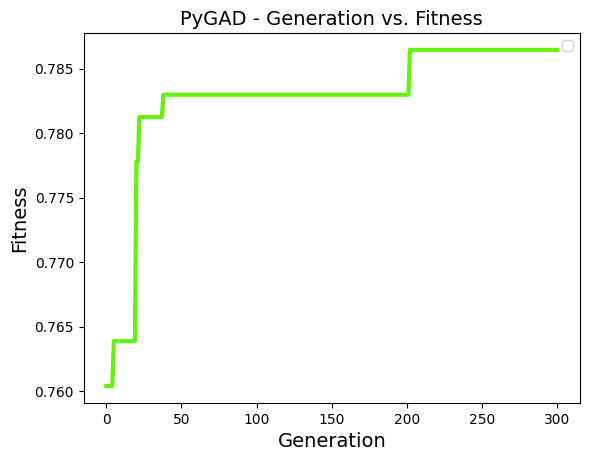


Melhores configurações encontradas:
- Fitness (Acurácia em CV): 0.7865
- Features selecionadas: ['Glucose', 'Insulin', 'BMI', 'Age']
- Número de camadas ocultas: 1
- Número de neurônios por camada: 41
- Taxa de aprendizado: 0.00147
Accuracy: 0.7344
Precision: 0.6429
F1 Score: 0.5854
Recall: 0.5373
Confusion Matrix:
 [[105  20]
 [ 31  36]]


In [20]:
n_features = X_train_scaled.shape[1]
feature_names = X.columns.tolist()

def fitness_func(ga_instance, solution, solution_idx):
    feature_mask = np.array(solution[:n_features]).astype(bool)
    
    # Penaliza se nenhuma característica for selecionada
    if not np.any(feature_mask):
        return -1.0  # PyGAD maximiza, então um valor baixo para penalizar

    # Arredonda os valores para garantir que sejam inteiros
    n_layers = int(round(solution[n_features]))
    n_neurons = int(round(solution[n_features + 1]))
    learning_rate = solution[n_features + 2]

    hidden_layer_sizes = tuple([n_neurons] * n_layers)
    X_sel = X_train_scaled[:, feature_mask]

    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        learning_rate_init=learning_rate
                        )

    try:
        # cross-validation com 3 folds
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean()
    except ValueError:
        # penaliza a solução em caso de erro
        return -1.0

    # PyGAD maximiza a função de fitness por padrão, então a acurácia é retornada diretamente.
    return score

# Define o espaço de busca
gene_space = [ [0, 1] for _ in range(n_features) ] + [ {'low': 1, 'high': 3, 'step': 1}, {'low': 10, 'high': 100, 'step': 1}, {'low': 0.0001, 'high': 0.1} ]

num_genes = len(gene_space)
ga_instance = pygad.GA(
    num_generations=300,
    num_parents_mating=10,
    sol_per_pop=10,
    num_genes=num_genes,
    fitness_func=fitness_func,
    gene_space=gene_space,
    parent_selection_type="tournament",
    crossover_type="two_points",
    mutation_type="random",
    mutation_probability=0.65,
)
ga_instance.run()
ga_instance.plot_fitness()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()

selected_features = best_solution[:n_features].astype(bool)
n_layers_best = int(round(best_solution[n_features]))
n_neurons_best = int(round(best_solution[n_features+1]))
lr_best = best_solution[n_features+2]

print("\nMelhores configurações encontradas:")
print(f"- Fitness (Acurácia em CV): {best_solution_fitness:.4f}")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de camadas ocultas: {n_layers_best}")
print(f"- Número de neurônios por camada: {n_neurons_best}")
print(f"- Taxa de aprendizado: {lr_best:.5f}")

# Treina o modelo final com os melhores parâmetros
clf_final = MLPClassifier(
    hidden_layer_sizes=(n_neurons_best,) * n_layers_best,
    learning_rate_init=lr_best,
    random_state=42
)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
y_pred = clf_final.predict(X_test_sel)

print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred),4))
print("F1 Score:", round(f1_score(y_test, y_pred),4))
print("Recall:", round(recall_score(y_test, y_pred),4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

## Genetic Algorithm (GA) + Extreme Learning Machine (ELM)

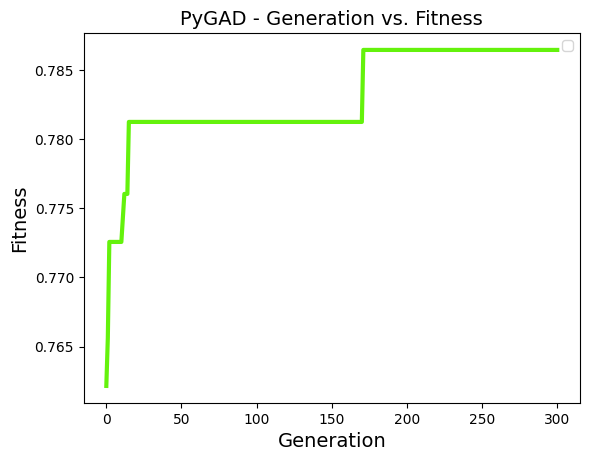


Melhores configurações encontradas:
- Fitness (Acurácia em CV): 0.7865
- Features selecionadas: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
- Número de neurônios da camada oculta: 12
Accuracy: 0.7188
Precision: 0.6182
F1 Score: 0.5574
Recall: 0.5075
Confusion Matrix:
 [[104  21]
 [ 33  34]]


In [21]:
n_features = X_train_scaled.shape[1]
feature_names = X.columns.tolist()

def fitness_func(ga_instance, solution, solution_idx):
    feature_mask = np.array(solution[:n_features]).astype(bool)
    
    # Penaliza se nenhuma característica for selecionada
    if not np.any(feature_mask):
        return -1.0  # PyGAD maximiza, então um valor baixo para penalizar

    # Arredonda os valores para garantir que sejam inteiros
    n_neurons = int(round(solution[n_features + 1]))

    X_sel = X_train_scaled[:, feature_mask]

    elm = ELMLayer(number_neurons=n_neurons, activation='relu')
    clf = ELMModel(elm)

    try:
        # cross-validation com 3 folds
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean()
    except ValueError:
        # penaliza a solução em caso de erro
        return -1.0

    # PyGAD maximiza a função de fitness por padrão, então a acurácia é retornada diretamente.
    return score

for _ in range(n_features):
    gene_space.append({'low': 0, 'high': 1, 'step': 1})
gene_space.append({'low': 10, 'high': 1000, 'step': 1})

num_genes = len(gene_space)
ga_instance = pygad.GA(
    num_generations=300,
    num_parents_mating=10,
    sol_per_pop=10,
    num_genes=num_genes,              
    fitness_func=fitness_func,
    gene_space=gene_space,
    parent_selection_type="tournament",
    crossover_type="two_points",
    mutation_type="random",
    mutation_probability=0.65
)
ga_instance.run()
ga_instance.plot_fitness()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()

selected_features = best_solution[:n_features].astype(bool)
n_neurons_best = int(round(best_solution[n_features + 1]))

print("\nMelhores configurações encontradas:")
print(f"- Fitness (Acurácia em CV): {best_solution_fitness:.4f}")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de neurônios da camada oculta: {n_neurons_best}")

# Treina o modelo final com os melhores parâmetros
elm = ELMLayer(number_neurons=n_neurons_best, activation='relu')
clf_final = ELMModel(elm)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
y_pred = clf_final.predict(X_test_sel)

print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred),4))
print("F1 Score:", round(f1_score(y_test, y_pred),4))
print("Recall:", round(recall_score(y_test, y_pred),4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))